In [2]:
import numpy as np
from scipy.sparse import spdiags
import matplotlib.pyplot as plt
import random

class EnvGeneration:
    def __init__(self, grid_size = 50, D = 0.2, velocity_vector = [lambda t: 3.0, lambda t: 2.0], source_pos = [-1.6, -1.6], 
                source_strength = 1, source_spread = 15, Lx=4, Ly=4, Lt=2, Nt=2000):
        self.n = grid_size
        self.Nt = Nt
        
        self.Lx = Lx
        self.Ly = Ly
        self.Lt = Lt

        self.dx = Lx / (grid_size - 1)
        self.dy = Ly / (grid_size - 1)
        self.dt = Lt / (Nt - 1)
        self.x = np.linspace(-Lx / 2, Lx / 2, grid_size)
        self.y = np.linspace(-Ly / 2, Ly / 2, grid_size)
        self.t = np.linspace(0, Lt, Nt)
        self.X, self.Y = np.meshgrid(self.x, self.y)

        self.D = D
        self.V_x, self.V_y = velocity_vector
        self.source_pos = source_pos
        self.source_strength = source_strength
        self.source_spread = source_spread

        self.u_new = np.zeros((grid_size, grid_size))
        self.u_old = np.zeros((grid_size, grid_size))

    def init_solution(self):
        self.f = np.zeros((self.n, self.n))
        for i in range(1, self.n-1):
            for j in range(1, self.n-1):
                self.f[i, j] = self.source_strength * np.exp(-self.source_spread * (((self.x[i] - self.source_pos[0]))**2 + ((self.y[j] - self.source_pos[1]))**2))
                """ if np.random.rand() < 0.1:
                    self.f[i, j] = 0
                else:
                    self.f[i, j] += np.random.normal(loc=0, scale=self.f[i, j] * 0.2) """

        self.u_vec = np.zeros((self.n * self.n))
        self.u_new = self.u_new.flatten()
        self.u_old = self.u_old.flatten()
        self.f_vec = self.f.flatten()

        self.E = self.sparseE(self.n)
        self.e = np.ones(self.n * self.n)

    def sparseE(self, n):
        total_nodes = n * n
        diagonals = np.zeros((5, total_nodes))
        main_diag = np.ones(total_nodes)
        diagonals[2, :] = main_diag
        upper_diag = np.ones(total_nodes - n)
        diagonals[3, :-n] = upper_diag
        lower_diag = np.ones(total_nodes - n)
        diagonals[1, n:] = lower_diag
        left_diag = np.ones(total_nodes - 1)
        left_diag[np.arange(1, total_nodes) % n == 0] = 0
        diagonals[0, 1:] = left_diag
        right_diag = np.ones(total_nodes - 1)
        right_diag[np.arange(total_nodes - 1) % n == n - 1] = 0
        diagonals[4, :-1] = right_diag
        offsets = [-n, -1, 0, 1, n]
        return spdiags(diagonals, offsets, total_nodes, total_nodes, format='csr')

    def C_Derivative(self, t, u_vec):
        D_fluct = self.D + np.random.normal(loc=0, scale=0.2)
        alpha_y = D_fluct / (self.dy**2) - self.V_y(t) / (2 * self.dy)
        alpha_x = D_fluct / (self.dx**2) - self.V_x(t) / (2 * self.dx)
        beta = - (2 * D_fluct / (self.dx**2) + 2 * self.D / (self.dy**2))
        gamma_x = D_fluct / (self.dx**2) + self.V_x(t) / (2 * self.dx)
        gamma_y = D_fluct / (self.dy**2) + self.V_y(t) / (2 * self.dy)

        row = [gamma_y * self.e, gamma_x * self.e, beta * self.e, alpha_x * self.e, alpha_y * self.e]
        diags = [-self.n, -1, 0, 1, self.n]

        A = spdiags(row, diags, self.n * self.n, self.n * self.n, format='csr')

        k = A.dot(u_vec) + self.f_vec
        return k

    def solve(self):
        for n in range(self.Nt - 1):
            k1 = self.C_Derivative(self.t[n], self.u_old)

            # Apply zero Dirichlet boundary conditions to k1
            k1[0:self.n] = 0  # Top boundary
            k1[-self.n:] = 0  # Bottom boundary
            k1[::self.n] = 0  # Left boundary
            k1[self.n - 1::self.n] = 0  # Right boundary

            k2 = self.C_Derivative(self.t[n] + self.dt / 2, self.u_old + k1 * self.dt / 2)

            # Apply zero Dirichlet boundary conditions to k2
            k2[0:self.n] = 0  # Top boundary
            k2[-self.n:] = 0  # Bottom boundary
            k2[::self.n] = 0  # Left boundary
            k2[self.n - 1::self.n] = 0  # Right boundary

            k3 = self.C_Derivative(self.t[n] + self.dt / 2, self.u_old + k2 * self.dt / 2)

            # Apply zero Dirichlet boundary conditions to k3
            k3[0:self.n] = 0  # Top boundary
            k3[-self.n:] = 0  # Bottom boundary
            k3[::self.n] = 0  # Left boundary
            k3[self.n - 1::self.n] = 0  # Right boundary

            k4 = self.C_Derivative(self.t[n] + self.dt, self.u_old + k3 * self.dt)

            # Apply zero Dirichlet boundary conditions to k4
            k4[0:self.n] = 0  # Top boundary
            k4[-self.n:] = 0  # Bottom boundary
            k4[::self.n] = 0  # Left boundary
            k4[self.n - 1::self.n] = 0  # Right boundary

            self.u_new = self.u_old + (1 / 6) * self.dt * (k1 + 2 * k2 + 2 * k3 + k4)
            self.u_old = self.u_new

        self.u_vec = self.u_new
        self.u = self.u_vec.reshape(self.n, self.n)
        self.u[self.u < 0] = 0
        
        # spread the solution to the edges
        self.u[0, :] = self.u[1, :]
        self.u[-1, :] = self.u[-2, :]
        self.u[:, 0] = self.u[:, 1]
        self.u[:, -1] = self.u[:, -2]
        
        if np.max(self.u) > 100:
            raise RuntimeError("Simulation diverged.")

    def plot_solution(self):
        plt.imshow(self.u, extent=[-self.Lx/2, self.Lx/2, -self.Ly/2, self.Ly/2], origin='lower', cmap='jet')
        plt.axis('off')
        plt.colorbar()
        # add the source position
        plt.scatter(self.source_pos[1], self.source_pos[0], c='r', marker='x')
        plt.show()
    
    def scale(self, max_val):
        self.u = max_val * (self.u - self.u.min()) / (self.u.max() - self.u.min())
        self.u = np.round(self.u)
    
    def random_source_positon(self):
        # between -1.6 and 1.6
        self.source_pos = [random.uniform(-1.6, 1.6), random.uniform(-1.6, 1.6)]
        
    def random_source_strength(self):
        self.source_strength = random.uniform(0.9, 1)
        
    def random_source_spread(self):
        self.source_spread = random.uniform(15, 25)
        
    def random_D(self):
        self.D = random.uniform(0.2, 0.35)
        
    def random_velocity_vector(self):
        if self.source_pos[1] < 0 and self.source_pos[0] < 0:
            # Source in bottom left corner, velocity should point towards top right
            random_x = random.uniform(0, 4) * self.n / 20
            random_y = random.uniform(0, 4) * self.n / 20
        elif self.source_pos[1] > 0 and self.source_pos[0] > 0:
            # Source in top right corner, velocity should point towards bottom left
            random_x = random.uniform(-4, 0) * self.n / 20
            random_y = random.uniform(-4, 0) * self.n / 20
        elif self.source_pos[1] < 0 and self.source_pos[0] > 0:
            # Source in top left corner, velocity should point towards bottom right
            random_x = random.uniform(0, 4) * self.n / 20
            random_y = random.uniform(-4, 0) * self.n / 20
        else:
            # Source in bottom right corner, velocity should point towards top left
            random_x = random.uniform(-4, 0) * self.n / 20
            random_y = random.uniform(0, 4) * self.n / 20

        self.V_x = lambda t: random_x
        self.V_y = lambda t: random_y
    
    def random_time(self):
        self.Lt = random.uniform(2, 4)
        self.t = np.linspace(0, self.Lt, self.Nt)
        
    def print_parameters(self):
        print(f"Grid size: {self.n}")
        print(f"D: {self.D}")
        print(f"Velocity vector: {self.V_x(0)}, {self.V_y(0)}")
        print(f"Source position: {[self.source_pos[1], self.source_pos[0]]}")
        print(f"Source strength: {self.source_strength}")
        print(f"Source spread: {self.source_spread}")
        print(f"Time: {self.Lt}")
    
    def save_solution(self, path, filename):
        np.save(path + filename, self.u)
    
    def save_image(self, path, filename):
        plt.imshow(self.u, extent=[-self.Lx/2, self.Lx/2, -self.Ly/2, self.Ly/2], origin='lower', cmap='jet')
        plt.axis('off')
        plt.savefig(path + filename + ".png")
        plt.close()
    
    def add_noise(self, noise_level):
        self.u += np.random.normal(loc=0, scale=np.mean(self.u) * noise_level, size=(self.n, self.n))
        self.u[self.u < 0] = 0

Grid size: 40
D: 0.21459814810595776
Velocity vector: 3.0, 10.0
Source position: [-0.21066970231265225, 1.5074715477954643]
Source strength: 0.9403308185803797
Source spread: 17.208380846657622
Time: 3.4246887072250933


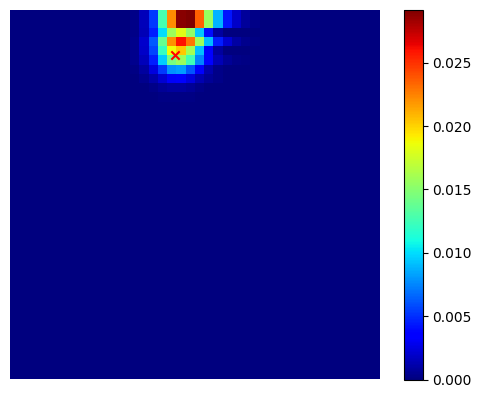

In [12]:
solver = EnvGeneration(grid_size=40, Nt = 200, velocity_vector=[lambda t: 3.0, lambda t: 10.0], source_pos=[-1.6, -1.6], source_strength=1, source_spread=15, D=0.2, Lx=4, Ly=4, Lt=2)
solver.random_source_positon()
solver.random_source_strength()
solver.random_source_spread()
solver.random_D()
solver.random_time()
solver.init_solution()
solver.print_parameters()

solver.solve()

solver.plot_solution()

#solver.save_solution("data/", "test.npy")

In [6]:
""" # save 10 images with grid size 100 with random parameters to the folder "images100random"
# create solver object
for i in range(10):
    solver = EnvGeneration(grid_size=100, Nt = 2000)
    solver.random_source_positon()
    solver.random_source_strength()
    solver.random_source_spread()
    solver.random_D()
    solver.random_velocity_vector()
    solver.random_time()
    solver.init_solution()
    solver.solve()
    solver.add_noise(0.1)
    # name the image using the parameter values, round the values to 2 decimal places
    solver.save_image("images100random/", f"{np.round(solver.source_pos[1], 2)}_{np.round(solver.source_pos[0], 2)}_{np.round(solver.source_strength, 2)}_{np.round(solver.source_spread, 2)}_{np.round(solver.D, 2)}_{np.round(solver.V_x(0), 2)}_{np.round(solver.V_y(0), 2)}_{np.round(solver.Lt, 2)}")
print("Done")

# save 10 images with grid size 50 with random parameters to the folder "images50random"
# create solver object
for i in range(10):
    solver = EnvGeneration(grid_size=50, Nt = 1000)
    solver.random_source_positon()
    solver.random_source_strength()
    solver.random_source_spread()
    solver.random_D()
    solver.random_velocity_vector()
    solver.random_time()
    solver.init_solution()
    solver.solve()
    solver.add_noise(0.1)
    solver.save_image("images50random/", f"{np.round(solver.source_pos[1], 2)}_{np.round(solver.source_pos[0], 2)}_{np.round(solver.source_strength, 2)}_{np.round(solver.source_spread, 2)}_{np.round(solver.D, 2)}_{np.round(solver.V_x(0), 2)}_{np.round(solver.V_y(0), 2)}_{np.round(solver.Lt, 2)}")
print("Done")

# save 10 images with grid size 20 with random parameters to the folder "images20random"
# create solver object
for i in range(10):
    solver = EnvGeneration(grid_size=20, Nt = 200)
    solver.random_source_positon()
    solver.random_source_strength()
    solver.random_source_spread()
    solver.random_D()
    solver.random_velocity_vector()
    solver.random_time()
    solver.init_solution()
    solver.solve()
    solver.add_noise(0.1)
    solver.save_image("images20random/", f"{np.round(solver.source_pos[1], 2)}_{np.round(solver.source_pos[0], 2)}_{np.round(solver.source_strength, 2)}_{np.round(solver.source_spread, 2)}_{np.round(solver.D, 2)}_{np.round(solver.V_x(0), 2)}_{np.round(solver.V_y(0), 2)}_{np.round(solver.Lt, 2)}")
print("Done") """

Done
Done
Done
